In [20]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
import os
import datetime
import matplotlib.dates as mdates
import pandas as pd

DATOS

In [49]:
directorio_actual = os.getcwd()

datos_sat = "datos\sst.day.mean.2024.nc"

# Crea la ruta al directorio padre (una carpeta atrás)
directorio_padre = os.path.abspath(os.path.join(directorio_actual, os.pardir))
ruta_archivo = os.path.join(directorio_padre,datos_sat)

# Datos simulados de boya
datos_boya = r'C:\Users\andre\Desktop\transformado.xlsx'

print(ruta_archivo)

C:\Users\andre\scripts\python\datos\sst.day.mean.2024.nc


In [13]:
# Abre el archivo NetCDF con xarray
ds = xr.open_dataset(ruta_archivo, decode_cf=False)
#Abre el archivo simulado de datos boya en Excel
df = pd.read_excel(datos_boya)

In [14]:
# Calcula la media de la SST a lo largo del tiempo
sst_mean = ds.sst.mean(dim='time')

C:\Users\andre\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [15]:
# Coordenadas de la boya AGL
boya_AGL = (-3.784, 43.894)

# Rango de niveles para el mapa
levs = np.arange(10, 20, 0.1)

In [16]:
print("Coordenadas disponibles:")
print(ds.coords) #Con esto veo el formato que tiene lon y lat
print(ds.time)#Con esto veo el formato de fecha, que empieza desde 01-01-1800

Coordenadas disponibles:
Coordinates:
  * time     (time) float64 8.181e+04 8.182e+04 ... 8.189e+04 8.189e+04
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
<xarray.DataArray 'time' (time: 76)>
array([81814., 81815., 81816., 81817., 81818., 81819., 81820., 81821., 81822.,
       81823., 81824., 81825., 81826., 81827., 81828., 81829., 81830., 81831.,
       81832., 81833., 81834., 81835., 81836., 81837., 81838., 81839., 81840.,
       81841., 81842., 81843., 81844., 81845., 81846., 81847., 81848., 81849.,
       81850., 81851., 81852., 81853., 81854., 81855., 81856., 81857., 81858.,
       81859., 81860., 81861., 81862., 81863., 81864., 81865., 81866., 81867.,
       81868., 81869., 81870., 81871., 81872., 81873., 81874., 81875., 81876.,
       81877., 81878., 81879., 81880., 81881., 81882., 81883., 81884., 81885.,
       81886., 81887., 81888., 81889.])
Coordinates:
  * time    

In [17]:
# Convierte las fechas a un formato legible
ds['time'] = xr.decode_cf(ds)['time']

C:\Users\andre\anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\andre\anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


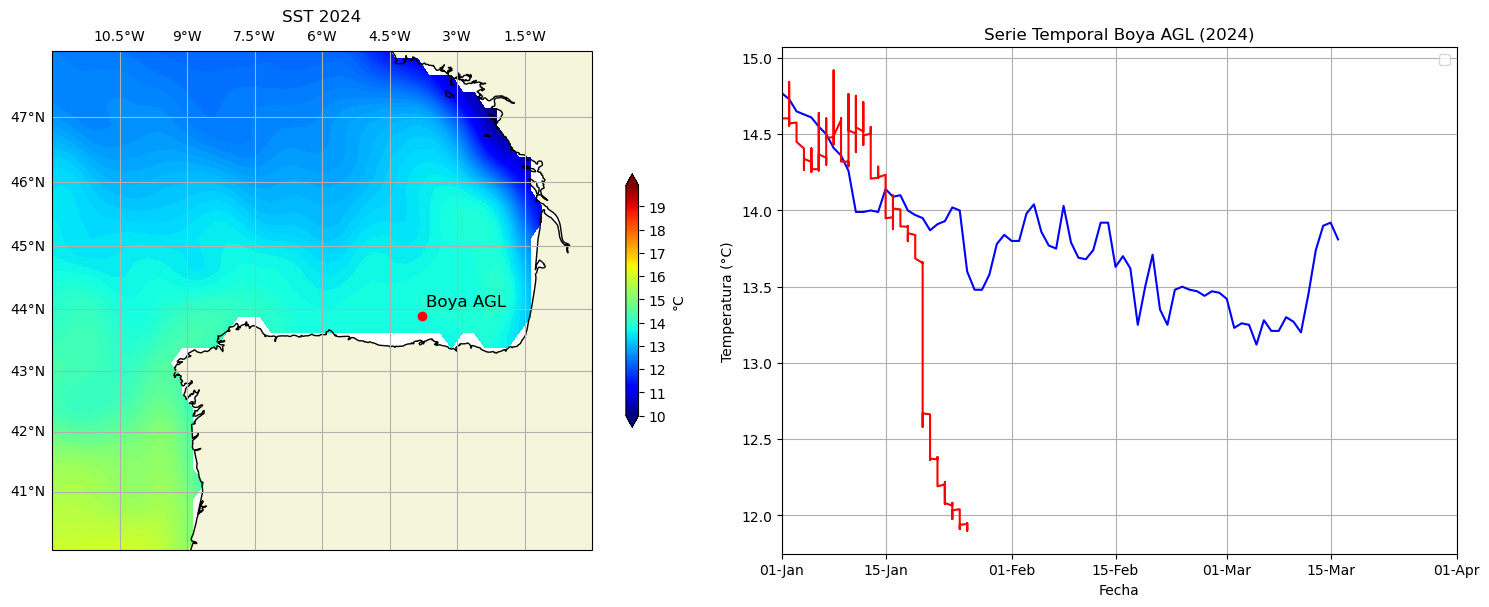

In [30]:

# Crear figura y subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Subgráfico 1: Mapa
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Mercator())

# Agrega los datos de SST media al mapa
mapa = ax1.contourf(ds.lon, ds.lat, sst_mean,
                    levs,
                    cmap='jet',
                    transform=ccrs.PlateCarree(),
                    extend='both')

# Agrega color beige a la tierra
ax1.add_feature(cfeature.LAND, color='beige')

# Agrega las líneas de costa y la cuadrícula
ax1.coastlines()
grid = ax1.gridlines(draw_labels=True)
grid.bottom_labels = False
grid.right_labels = False

plt.colorbar(mapa,
            ax=ax1,  # Indica el eje al que se añadirá la barra de color
            label="°C",  # Etiqueta del colorbar
            shrink=0.5)

# Agrega el punto de la boya
ax1.scatter(boya_AGL[0], boya_AGL[1],
            color='red',
            marker='o',
            transform=ccrs.PlateCarree())

# Agrega texto en el punto especificado
ax1.text(boya_AGL[0] + 0.1, boya_AGL[1] + 0.15,
        'Boya AGL',
        color='black',
        fontsize=12,
        transform=ccrs.PlateCarree())

# Define los límites de la región que deseas mostrar
lon_min, lon_max = -12, 0
lat_min, lat_max = 40, 48

# Establece los límites de la región en los ejes
ax1.set_extent((lon_min, lon_max, lat_min, lat_max))
ax1.set_title("SST 2024")

# Subgráfico 2: Línea temporal. Pasar primero lon y luego lat. Como los datos de lon tiene rango de 0-360, 
#hay que  pasarle % 360, le suma 360 grados repetidamente hasta que la longitud sea positiva y esté en el rango de 0 a 360 grados. Si ya es +, no hace nada
#ax2.plot(ds.time(), ds.sst.sel(lon = -3.78 % 360, lat = 43.89, method='nearest'), color='blue')
#fechas_dia_mes = ds.time.dt.strftime('%d-%m-%Y')
ax2.plot(ds.time, ds.sst.sel(lon = -3.78 % 360, lat = 43.89, method='nearest'), color='blue')
ax2.set_xlabel('Fecha')
myFmt = mdates.DateFormatter('%d-%b')
ax2.xaxis.set_major_formatter(myFmt)

# Establecer los límites del eje x
inicio = datetime.datetime(2024, 1, 1)
fin = datetime.datetime(2024, 4, 1)
ax2.set_xlim([inicio, fin])

ax2.set_ylabel('Temperatura (°C)')

ax2.set_title('Serie Temporal Boya AGL (2024)')
ax2.grid()

# Pinta datos_boya con variación horaria
ax2.plot(df.Time, df.WaterTemperature, color='red')

ax2.legend()

# Ajustar diseño y mostrar el gráfico
plt.tight_layout()
plt.show()




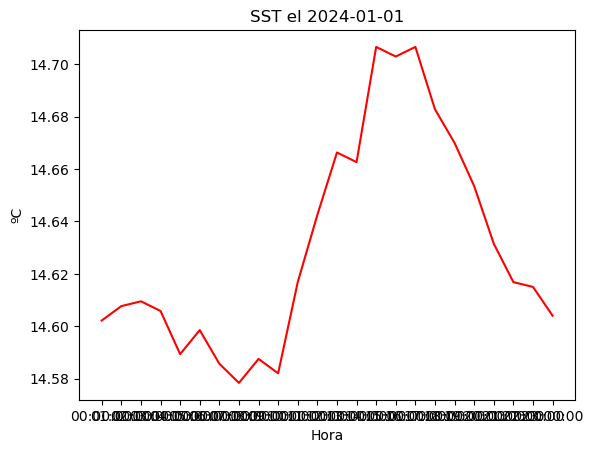

In [51]:
# Selecciona la fecha concreta que deseas plotear
fecha_concreta = '2024-01-01'  

# Filtra el DataFrame para seleccionar solo los datos correspondientes a la fecha concreta
datos_fecha_concreta = df[df['Time'] == fecha_concreta]

# Plotea los datos correspondientes a la fecha concreta
plt.plot(datos_fecha_concreta['Hour'], datos_fecha_concreta['WaterTemperature'], color='red')

# Personaliza el gráfico
plt.title('SST el ' + fecha_concreta)
plt.xlabel('Hora')
plt.ylabel('ºC')

# Muestra el gráfico
plt.show()


C:\Users\andre\anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\andre\anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


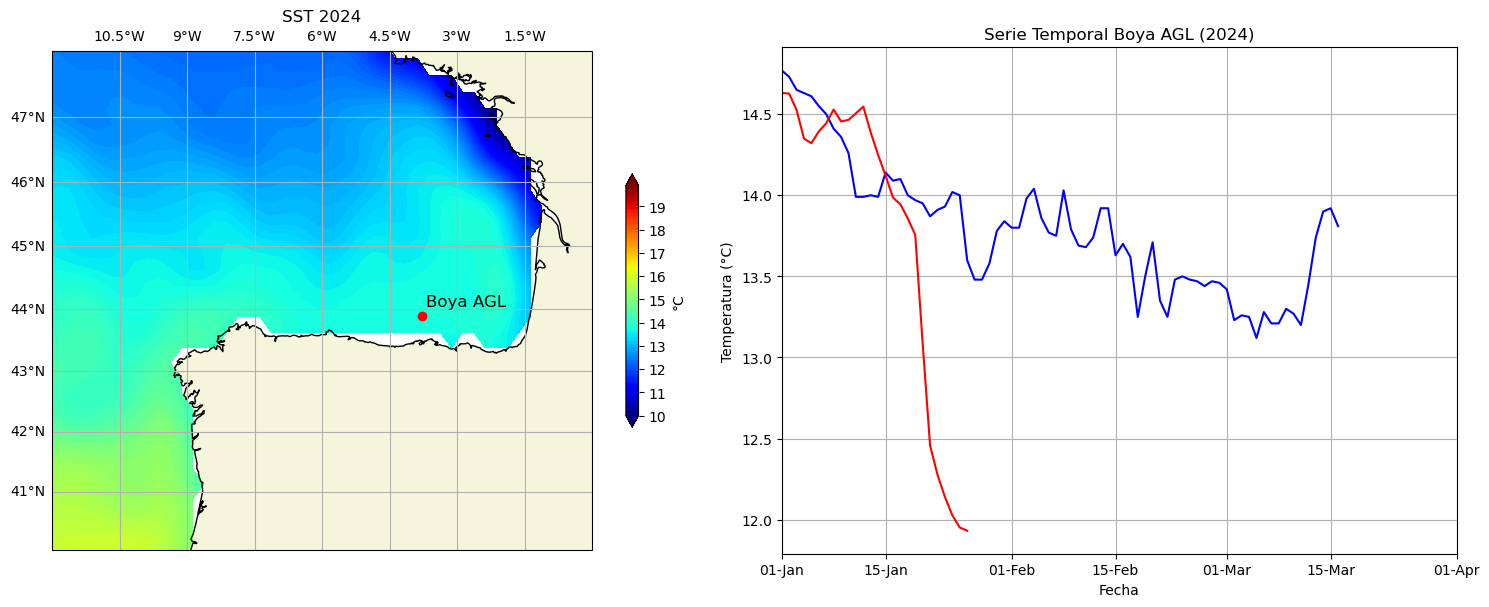

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Subgráfico 1: Mapa
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Mercator())

# Agrega los datos de SST media al mapa
mapa = ax1.contourf(ds.lon, ds.lat, sst_mean,
                    levs,
                    cmap='jet',
                    transform=ccrs.PlateCarree(),
                    extend='both')

# Agrega color beige a la tierra
ax1.add_feature(cfeature.LAND, color='beige')

# Agrega las líneas de costa y la cuadrícula
ax1.coastlines()
grid = ax1.gridlines(draw_labels=True)
grid.bottom_labels = False
grid.right_labels = False

plt.colorbar(mapa,
            ax=ax1,  # Indica el eje al que se añadirá la barra de color
            label="°C",  # Etiqueta del colorbar
            shrink=0.5)

# Agrega el punto de la boya
ax1.scatter(boya_AGL[0], boya_AGL[1],
            color='red',
            marker='o',
            transform=ccrs.PlateCarree())

# Agrega texto en el punto especificado
ax1.text(boya_AGL[0] + 0.1, boya_AGL[1] + 0.15,
        'Boya AGL',
        color='black',
        fontsize=12,
        transform=ccrs.PlateCarree())

# Define los límites de la región que deseas mostrar
lon_min, lon_max = -12, 0
lat_min, lat_max = 40, 48

# Establece los límites de la región en los ejes
ax1.set_extent((lon_min, lon_max, lat_min, lat_max))
ax1.set_title("SST 2024")

# Subgráfico 2: Línea temporal. Pasar primero lon y luego lat. Como los datos de lon tiene rango de 0-360, 
#hay que  pasarle % 360, le suma 360 grados repetidamente hasta que la longitud sea positiva y esté en el rango de 0 a 360 grados. Si ya es +, no hace nada
#ax2.plot(ds.time(), ds.sst.sel(lon = -3.78 % 360, lat = 43.89, method='nearest'), color='blue')
#fechas_dia_mes = ds.time.dt.strftime('%d-%m-%Y')
ax2.plot(ds.time, ds.sst.sel(lon = -3.78 % 360, lat = 43.89, method='nearest'), color='blue')
ax2.set_xlabel('Fecha')
myFmt = mdates.DateFormatter('%d-%b')
ax2.xaxis.set_major_formatter(myFmt)

# Establecer los límites del eje x
inicio = datetime.datetime(2024, 1, 1)
fin = datetime.datetime(2024, 4, 1)
ax2.set_xlim([inicio, fin])

ax2.set_ylabel('Temperatura (°C)')

ax2.set_title('Serie Temporal Boya AGL (2024)')
ax2.grid()

# Calcula la media de 'WaterTemperature' por día
df_mean = df.groupby(df['Time'].dt.date)['WaterTemperature'].mean().reset_index()

# Plotea la media de 'WaterTemperature' por día
ax2.plot(df_mean.Time, df_mean.WaterTemperature, color='red')

#ax2.legend()

# Ajustar diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

In [52]:
#mirar leyenda
#ajustar mejor datos ficticios
#poner datos de matlab de climatologia aqui